# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В распоряжении набор фотографий людей с указанием возраста.

## Описание данных

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке `/datasets/faces/`.

В распоряжении одна папка со всеми изображениями (`/final_files`) и CSV-файл `labels.csv` с двумя колонками: `file_name` и `real_age`.

Извлечь данные из папки вам поможет новый метод ImageDataGenerator — `flow_from_dataframe(dataframe, directory, ...)`.

# Загрузка и исследовательский анализ данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

Загрузим данные в переменную `labels`

In [ ]:
try:
    labels = pd.read_csv('https://code.s3.yandex.net/datasets/faces/labels.csv')
except:
    labels = pd.read_csv('/datasets/faces/labels.csv')

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=59)

Found 7591 validated image filenames.


В датасете почти 7600 фотографий. У нас два пути: либо мы проводим аугментацию данных, т.е. искусственно увеличиваем, либо используем предобученную на ImageNet сеть. Далее выберем наиболее эффективный.

In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
labels.head()

file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17

Построим график распределения возраста людей.

In [ ]:
hist = px.histogram(labels, x='real_age', nbins=100, title='Распределение возраста покупателей')

hist.update_layout(
    xaxis_title="Возраст",
    yaxis_title="Частота"
)

hist.show()

На данном графике можно увидеть, что возраст наибольшего количества покупателей варьируется от 15 до 40 лет.

Получим пары "картинка — метка" с помощью `next()`

In [ ]:
features, target = next(train_gen_flow)

In [ ]:
print('Размерность \'features\':', features.shape)
print('Размерность \'target\':', target.shape)

Размерность 'features': (32, 224, 224, 3)
Размерность 'target': (32,)


Имеем 4D тензор, в батче 32 картинки 224×224 и с 3 каналами. В `target` соответвующий возраст.

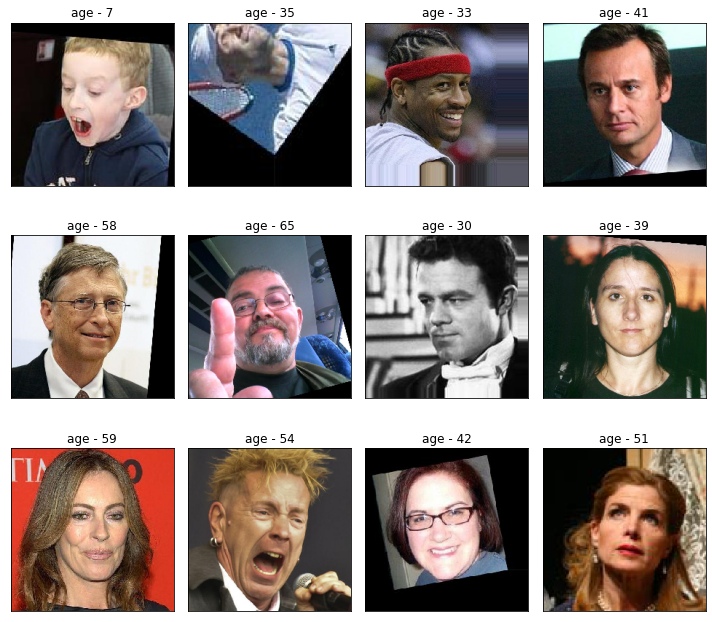

In [ ]:
fig = plt.figure(figsize=(10, 10))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'age - {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Выводы**

1. Датасет состоит из 7600 фотографий людей разных возрастов;
2. Возраст варьируется от 1 до 100 лет;
3. Наиболее число людей возрастом от 15 до 40 лет;
4. Некоторые фотографии ротированы.

Будем использовать backbone, предобученный на ImageNet.

# Обучение модели

``` python
import pandas as pd
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Flatten, AvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
```

``` python
def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       horizontal_flip=True,
                                       validation_split=0.20)

    train_gen_flow = train_datagen.flow_from_dataframe(dataframe = labels,
                                                       directory = (path + 'final_files/'),
                                                       x_col='file_name',
                                                       y_col='real_age',
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       shuffle=True,
                                                       class_mode='raw',
                                                       subset='training',
                                                       seed=59)
    return train_gen_flow
```

``` python
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.20)

    test_gen_flow = test_datagen.flow_from_dataframe(dataframe = labels,
                                                     directory = (path + 'final_files/'),
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224),
                                                     batch_size=32,
                                                     shuffle=True,
                                                     class_mode='raw',
                                                     subset='validation',
                                                     seed=59)
    return test_gen_flow
```

``` python
def create_model(input_shape):

    optimizer = Adam(lr=0.0001)

    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)

    model = Sequential()

    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))

    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model
```

``` python
def train_model(model, train_data, test_data, batch_size=None, epochs=14,
               steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model
```

```
Train for 190 steps, validate for 48 steps
Epoch 1/14
190/190 - 47s - loss: 236.3849 - mae: 10.9058 - val_loss: 865.3893 - val_mae: 24.5286
Epoch 2/14
190/190 - 38s - loss: 76.2173 - mae: 6.5824 - val_loss: 778.5566 - val_mae: 22.9757
Epoch 3/14
190/190 - 39s - loss: 48.0090 - mae: 5.2675 - val_loss: 273.7050 - val_mae: 12.3173
Epoch 4/14
190/190 - 38s - loss: 37.7939 - mae: 4.6951 - val_loss: 119.8429 - val_mae: 8.0750
Epoch 5/14
190/190 - 38s - loss: 25.8861 - mae: 3.9088 - val_loss: 75.1220 - val_mae: 6.5221
Epoch 6/14
190/190 - 38s - loss: 22.3368 - mae: 3.6138 - val_loss: 83.4295 - val_mae: 6.7194
Epoch 7/14
190/190 - 39s - loss: 17.7604 - mae: 3.2234 - val_loss: 66.7849 - val_mae: 6.0686
Epoch 8/14
190/190 - 38s - loss: 14.2506 - mae: 2.8997 - val_loss: 63.3682 - val_mae: 5.9116
Epoch 9/14
190/190 - 39s - loss: 12.2176 - mae: 2.6499 - val_loss: 76.6912 - val_mae: 6.4468
Epoch 10/14
190/190 - 38s - loss: 10.7231 - mae: 2.4857 - val_loss: 72.7164 - val_mae: 6.2500
Epoch 11/14
190/190 - 38s - loss: 9.7553 - mae: 2.3569 - val_loss: 70.3763 - val_mae: 6.3632
Epoch 12/14
190/190 - 38s - loss: 8.3459 - mae: 2.1900 - val_loss: 63.6703 - val_mae: 5.8895
Epoch 13/14
190/190 - 38s - loss: 8.4011 - mae: 2.1694 - val_loss: 60.6614 - val_mae: 5.8231
Epoch 14/14
190/190 - 38s - loss: 7.8702 - mae: 2.1022 - val_loss: 58.1603 - val_mae: 5.7129

48/48 - 8s - loss: 58.1603 - mae: 5.7129
Test MAE: 5.7129
```

На предобученной модели ResNet50 с 14 эпохами необходимая **метрика достигнута**.

# Анализ обученной модели

Для достижения необходимой метрики была использована сверточная сеть ResNet50, предобученная на датасете ImageNet.

Ранее я упомянул два варианта: аугментируем данные и сами подбираем слои для нейронной сети или используем уже предобученную сеть на ImageNet. Второй вариант оказался намного быстрее и показал лучшие результаты.

Также стоит отметить, что использовался горизонтальный флип, т.к. он немного все же улучшил метрику.

При обучении модели, в качестве функции потери я, по рекомендации, использовал Mean Squared Error, а в качестве метрики - Mean Absolute Error. Это позволяет модели оптимизировать параметры с учетом MSE, но в то же время предоставлять MAE в качестве более интерпретируемой метрики для оценки ее точности.

Ключевые параметры и характеристики:

- optimizer - Adam()
- learning rate = 0.0001
- loss = `mean_squared_error`
- metrics = `mae`
- epochs = 14
- validation_split = 0.2

Метрика MAE на тестовой выборке - 5.71, функция потерь - 58.2

**Модель отлично подойдет для рекомендаций на основе возрастных групп, но не подходит для точного опредления возраста при продаже алкоголя из-за ошибки в 5-6 лет.**

# Вывод

**Подготовка данных:**

В ходе EDA, мы загрузили датасет, состоящий из 7600 строк и 2 столбцов, использовали динамический загрузчик данных ImageDataGenerator.

Графически описали распределение возрастов покупателей, а также вывели 12 картинок из датасета.

**Обучение модели:**

Мы обучили модель ResNet50, предобученную на наборе данных ImageNet и в итоге она показала метрику MAE на тестовой выборке - 5.7 лет. Задача выполнена.

**Анализ обученной модели:**

В этой главе описаны основные характеристики модели и основные этапы при построении модели.

**Рекомендации для улучшения результата:**

Для улучшения результатов модели, можно поэкспериментировать с гиперпараметрами, как learning rate, batch_size, увеличить количество эпох, а также провести более масштабную аугментацию данных.

Добавление методов регуляризации, таких как dropout или L2 регуляризация, может помочь снизить переобучение модели и улучшить ее обобщающую способность.

Также может помочь пополнение датасета новыми данными.